In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pdb

import pickle
import adniEnsemble as adens

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


## MRI

In [43]:
## prepare data with appropriate features and randomization
shuffled_df = mridf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e0, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
sensitivity_test, specificity_test = adens.SensiSpeci(testing_Y, mlmodel.predict(testing_X))
# test model - training data
sensitivity_train, specificity_train = adens.SensiSpeci(training_Y, mlmodel.predict(training_X))

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 82.65, Specificity: 92.08
Train: Sensitivity = 86.00, Specificity: 94.82


In [41]:
shuffled_df.mean()

RID        2.125878e+03
Gender     1.465367e+00
Educ       1.592942e+01
Age        7.583987e+01
APOE       8.691072e-02
MMSE       2.593732e+01
mri_001    9.150603e+02
mri_002    4.616630e+03
mri_003    1.782478e+03
mri_004    2.463596e+00
mri_005    1.513138e+03
mri_006    1.390555e+03
mri_007    4.939721e+02
mri_008    1.684568e+03
mri_009    1.501626e+03
mri_010    3.123487e+02
mri_011    1.090576e+03
mri_012    3.016261e+03
mri_013    1.093178e+03
mri_014    1.651651e+03
mri_015    2.367179e+03
mri_016    2.365196e+04
mri_017    7.369565e+03
mri_018    1.739098e+03
mri_019    1.226668e+03
mri_020    4.439368e+03
mri_021    1.964076e+03
mri_022    8.302933e+02
mri_023    1.636909e+03
mri_024    5.697299e+02
               ...     
mri_104    2.937956e+03
mri_105    2.424609e+00
mri_106    1.440391e+04
mri_107    4.635217e+03
mri_108    1.453106e+03
mri_109    1.011248e+03
mri_110    2.248129e+03
mri_111    8.199811e+02
mri_112    3.077109e+03
mri_113    2.187932e+03
mri_114    6.808

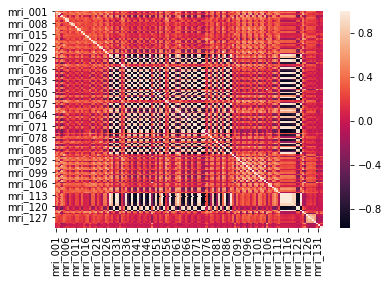

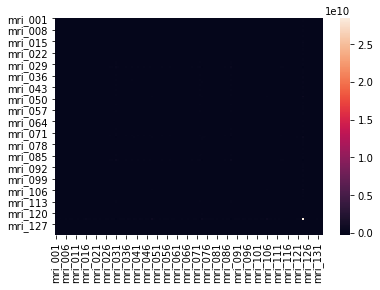

In [50]:
sns.heatmap(shuffled_df[features].cov())
plt.show()
sns.heatmap(mridf[features].cov())
plt.show()

In [ ]:
amyloiddf['DX_bin'] = np.where(amyloiddf["DX"]=="CN", 0, 1)
grid_out = adens.ttSplitWithGridSearch('svm', svc_param_grid, 4, 
                                              amyloiddf, features, 'DX_bin', 0.8, 0) 

In [175]:
import tensorflow as tf
from tensorflow import keras

shuffled_df = mridf.sample(frac=1, random_state=1)
# features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
features = mri_vars
# shuffled_df[features] = (shuffled_df[features]-shuffled_df[features].mean())/(shuffled_df[features].std())
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))
num_samples_vald = int(np.round(num_samples*validation_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

In [188]:
# specify the model
dlmodel_def = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# perform cross validation to choose number of epochs
max_epochs = 100
validation_fraction = 1/8 # show as a fraction of training data
train_acc, val_acc, epoch_arr = trainDeepLearningModelCV(dlmodel_def, training_X, training_Y, 
                                                         validation_fraction, max_epochs)

Training CV number: 0
Training CV number: 1
Training CV number: 2
Training CV number: 3
Training CV number: 4
Training CV number: 5
Training CV number: 6
Training CV number: 7


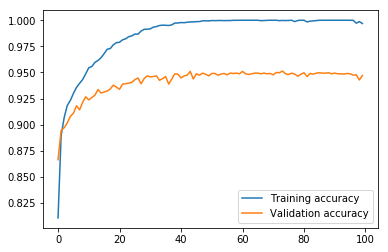

In [189]:
plt.plot(epoch_arr, np.mean(train_acc, axis=0), label='Training accuracy')
plt.plot(epoch_arr, np.mean(val_acc, axis=0), label='Validation accuracy')
plt.legend()
plt.show()

In [191]:
dlmodel = dlmodel_def
dlmodel.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs_from_cv = 40 # pick this from the plot of training and validation performance
train_mean_list = np.mean(training_X, axis=0)
train_std_list = np.std(training_X, axis=0)
dlmodel_history = dlmodel.fit((training_X - train_mean_list)/train_std_list, training_Y, epochs=epochs_from_cv, verbose=1)

Epoch 1/40
3038/3038 [==============================] - 2s 809us/step - loss: 0.4198 - acc: 0.8153
Epoch 2/40
3038/3038 [==============================] - 0s 58us/step - loss: 0.2882 - acc: 0.8947
Epoch 3/40
3038/3038 [==============================] - 0s 59us/step - loss: 0.2503 - acc: 0.9098
Epoch 4/40
3038/3038 [==============================] - 0s 60us/step - loss: 0.2262 - acc: 0.9207
Epoch 5/40
3038/3038 [==============================] - 0s 57us/step - loss: 0.2026 - acc: 0.9286
Epoch 6/40
3038/3038 [==============================] - 0s 55us/step - loss: 0.1888 - acc: 0.9305
Epoch 7/40
3038/3038 [==============================] - 0s 53us/step - loss: 0.1759 - acc: 0.9404
Epoch 8/40
3038/3038 [==============================] - 0s 57us/step - loss: 0.1626 - acc: 0.9444
Epoch 9/40
3038/3038 [==============================] - 0s 56us/step - loss: 0.1492 - acc: 0.9529
Epoch 10/40
3038/3038 [==============================] - 0s 57us/step - loss: 0.1443 - acc: 0.9503
Epoch 11/40
3038/3

In [193]:
print("Test accuracy is: %.2f%%" % (100*dlmodel.evaluate((testing_X-train_mean_list)/train_std_list, testing_Y)[1]))

759/759 [==============================] - 0s 29us/step
Test accuracy is: 96.44%


In [187]:
def trainDeepLearningModelCV(model, data_X, data_Y, val_frac, train_epochs):
    num_cv = int(np.round(1/val_frac))
    val_perf = np.zeros((num_cv, train_epochs))
    train_perf = np.zeros((num_cv, train_epochs))
    
    for cvn in range(0, num_cv):
        print("Training CV number: %d" % (cvn))
        # split training and validation data
        train_X_ns, val_X_ns, train_Y, val_Y = train_test_split(data_X, data_Y, 
                                                          train_size=1-val_frac, test_size=val_frac, shuffle=True)
        # standardize validation and training data using training data
        mean_list_train = np.mean(train_X_ns, axis=0)
        std_list_train = np.std(train_X_ns, axis=0)
        train_X = (train_X_ns - mean_list_train)/std_list_train
        val_X = (val_X_ns - mean_list_train)/std_list_train
#         pdb.set_trace()
        # create model instance and compile it
        temp_model = keras.Sequential.from_config(model.get_config())
        temp_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
        # train model
        temp_model.fit(train_X, train_Y, 
                       epochs=train_epochs, 
                       validation_data=(val_X, val_Y),
                       verbose=0)
        epoch_array = temp_model.history.epoch
        val_perf[cvn,:] = temp_model.history.history['val_acc']
        train_perf[cvn,:] = temp_model.history.history['acc']
    
    return train_perf, val_perf, epoch_array
        

In [81]:
[gridout['test_score']['accuracy'] for gridout in pickle.load(open('../Dataset/ProcessedFiles/mri_svm_cv.pckl','rb'))]

[94.82758620689656,
 93.89920424403184,
 94.29708222811671,
 94.29708222811671,
 94.9602122015915,
 95.09283819628646,
 93.89920424403184,
 93.89920424403184,
 94.56233421750663,
 94.6949602122016]

In [134]:
len(dlmodel.history.epoch)

40

In [120]:
dlmodel2 = keras.Sequential.from_config(dlmodel_def.get_config())

In [184]:
np.mean(training_X, axis=0)

array([9.15795425e+02, 4.61654361e+03, 1.78175395e+03, 2.46451020e+00,
       1.51201399e+03, 1.38911833e+03, 4.93540791e+02, 1.68351186e+03,
       1.50098009e+03, 3.11787100e+02, 1.09157979e+03, 3.01413726e+03,
       1.09210133e+03, 1.65156254e+03, 2.36691162e+03, 2.36768900e+04,
       7.37522400e+03, 1.74113381e+03, 1.22789952e+03, 4.44527321e+03,
       1.96530386e+03, 8.28737565e+02, 1.63655300e+03, 5.69464842e+02,
       3.08753622e+02, 5.54979559e+03, 2.40612796e+03, 1.71273149e+03,
       4.69694531e+03, 3.88355429e+03, 1.62105734e+04, 2.47078117e+03,
       2.41466787e+03, 5.58392363e+03, 2.24847947e+03, 2.62189059e+03,
       9.36585303e+03, 3.11005949e+03, 3.54855896e+03, 7.61560484e+03,
       2.42443372e+03, 2.23459793e+03, 9.12451399e+03, 3.87662266e+03,
       1.89882732e+03, 6.54912969e+03, 2.21883574e+03, 1.71612679e+03,
       1.40181753e+04, 3.82677778e+03, 1.83451076e+03, 6.25050013e+02,
       2.10709964e+03, 1.95715179e+03, 2.06478053e+03, 4.60535155e+03,
      

In [174]:
np.std(testing_X, axis=0)

array([0.97387561, 0.99305795, 0.99436203, 0.97741463, 1.01531963,
       1.05354033, 1.04984089, 1.04106934, 1.02323404, 1.10946739,
       0.98804712, 1.02069577, 1.01806288, 1.00663498, 1.02708954,
       1.01514272, 1.01933476, 0.97568242, 0.96384405, 0.99114364,
       0.96109927, 1.03266594, 0.99027399, 0.95966126, 0.98259232,
       0.99612448, 1.03520466, 1.00787719, 1.00650149, 0.99619941,
       1.00447023, 0.98103941, 1.04078523, 1.01268177, 1.0081796 ,
       0.98663377, 1.02945999, 1.01046258, 1.00013398, 0.99944014,
       0.99822547, 0.99187365, 1.02434358, 1.00422317, 0.99260317,
       1.017912  , 0.9987863 , 0.99274952, 1.02582515, 1.01045555,
       0.98871247, 1.00658492, 1.00998201, 0.99542072, 1.00053063,
       1.03319429, 1.04318196, 1.00613553, 1.00639471, 1.00891163,
       1.04729688, 1.00175722, 1.01481275, 1.03411475, 1.02212407,
       1.00534917, 0.98914459, 1.00677608, 1.00360374, 0.96746057,
       0.98073618, 0.98030583, 0.99819306, 0.99414644, 0.99437

In [68]:
len(testing_Y)

759

In [102]:
mean_list = np.mean(train_X, axis=0)
std_list = np.std(train_X, axis=0)

print(np.std((test_X-mean_list)/std_list))
print(std_list)

Gender        1.000044
Age           0.947217
Educ          0.969644
APOE          1.250293
amyloid_01    0.947716
amyloid_02    0.900736
amyloid_03    0.972888
amyloid_04    0.986007
amyloid_05    1.079427
amyloid_06    1.004542
dtype: float64
Gender        0.499898
Age           7.204899
Educ          2.659972
APOE          0.247146
amyloid_01    0.314005
amyloid_02    0.324637
amyloid_03    0.312845
amyloid_04    0.276639
amyloid_05    0.148476
amyloid_06    0.497561
dtype: float64
